[View in Colaboratory](https://colab.research.google.com/github/kyokicchi/kaggle_codes/blob/master/trainXGBmodel.ipynb)

In [1]:
!pip install --upgrade xgboost

    100% |████████████████████████████████| 15.8MB 2.5MB/s 
  Found existing installation: xgboost 0.7.post4
    Uninstalling xgboost-0.7.post4:
      Successfully uninstalled xgboost-0.7.post4


In [0]:
import xgboost as xgb
import numpy as np
import pandas as pd
from google.colab import drive
from google.colab import files
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, mean_squared_error
import pickle
import matplotlib.pyplot as plt
%matplotlib inline



In [3]:
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
%cd ../content/gdrive/My Drive/projects/
%ls

/content/gdrive/My Drive/projects
model_LGB.sav  model_XGB.sav  user_test_n.csv
model_NN.h5    output.csv     user_train_n.csv


In [0]:
s_data = 'user_train_n.csv'
filename = 'model_XGB.sav'
s_col_tgt = 'transactionRevenue_sum'
l_col_drop = [s_col_tgt]


In [6]:
%%time
df_train = pd.read_csv(s_data, index_col = 0)

<string>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 8.24 s, sys: 1 s, total: 9.24 s
Wall time: 12.2 s


In [7]:
%%time
df_y = df_train[s_col_tgt]
df_x = df_train.drop(l_col_drop, axis=1)

CPU times: user 61.1 ms, sys: 181 ms, total: 242 ms
Wall time: 243 ms


In [8]:
%%time
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y)
x_eval, x_valid, y_eval, y_valid = train_test_split(x_test, y_test)


CPU times: user 1.07 s, sys: 137 ms, total: 1.2 s
Wall time: 1.2 s


In [9]:
%env JOBLIB_TEMP_FOLDER=/tmp



env: JOBLIB_TEMP_FOLDER=/tmp


In [0]:
model = xgb.XGBRegressor(

    n_estimators=100, 
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
)

params = {
 'max_depth':[x for x in range(3,10,2)],
 'min_child_weight':[x for x in range(1,6,2)]
}


cv = model_selection.GridSearchCV(estimator = model, param_grid = params, n_jobs=-1, cv=3, verbose = 2)

In [20]:
x = df_x[:][:5000]
y =  df_y[:][:5000]

x.shape, y.shape

((5000, 57), (5000,))

In [21]:
%%time

cv.fit(x,y)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=   0.4s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=   0.4s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=   0.3s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] .................. max_depth=3, min_child_weight=3, total=   0.3s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] .................. max_depth=3, min_child_weight=3, total=   0.3s
[CV] max_depth=3, min_child_weight=5 .................................
[CV] .................. max_depth=3, min_child_weight=3, total=   0.3s
[CV] max_depth=3

[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   15.8s finished


CPU times: user 1.22 s, sys: 93.5 ms, total: 1.31 s
Wall time: 16.7 s


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [22]:
print(cv.best_params_, cv.best_score_)

{'max_depth': 5, 'min_child_weight': 5} 0.28820228336545994


In [23]:
%%time
model = xgb.XGBRegressor(**cv.best_params_)
model.fit(df_x, df_y)


CPU times: user 2min 54s, sys: 514 ms, total: 2min 55s
Wall time: 2min 55s


In [24]:
%%time
pickle.dump(model, open(filename, 'wb'))

#files.download(filename) 

CPU times: user 35 µs, sys: 2.98 ms, total: 3.01 ms
Wall time: 551 ms


In [25]:
pred = model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print(rmse)

0.0031198741155470874


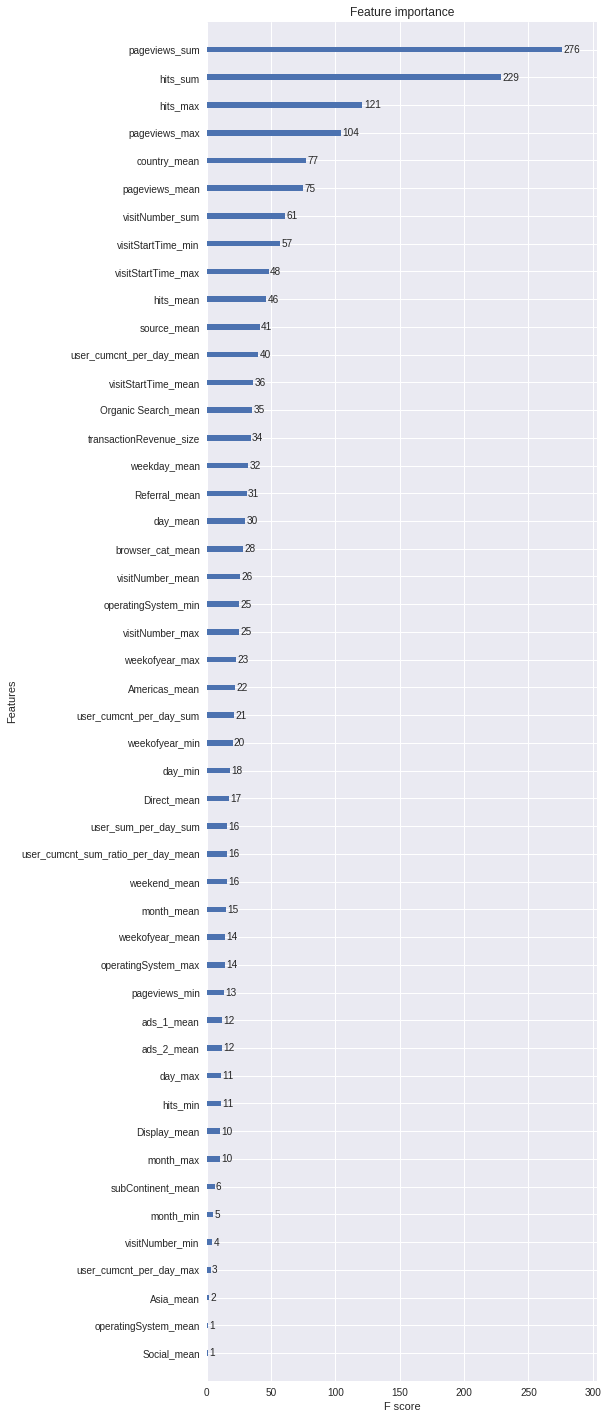

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(7, 25))
xgb.plot_importance(model, ax=ax)
plt.show()